In [1]:
import os
import sys
import math
import logging
from pathlib import Path

import numpy as np
import scipy as sp
import sklearn
import statsmodels.api as sm
from statsmodels.formula.api import ols

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("whitegrid")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

In [2]:
from enadepy.loaders import read_interm
from enadepy.helpers import list_cols_socioecon
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing

In [3]:
df = read_interm('../data/interim/microdados_enade_ata_2016a2018_priv.csv')

In [4]:
df.head()

,NU_ANO,CO_IES,CO_GRUPO,NU_IDADE,TP_SEXO,ANO_FIM_EM,ANO_IN_GRAD,QE_I01,QE_I02,QE_I04,QE_I05,QE_I06,QE_I07,QE_I08,QE_I09,QE_I10,QE_I11,QE_I12,QE_I13,QE_I14,QE_I15,QE_I17,QE_I18,QE_I19,QE_I20,QE_I21,QE_I22,QE_I23,QE_I24,QE_I25
0,2016,322,19,21,F,2012,2013,A,A,C,D,A,A,A,C,E,E,A,A,A,A,A,A,A,B,B,B,B,E,A
1,2016,322,19,29,F,2012,2013,A,A,A,A,B,C,A,E,E,E,A,A,A,A,A,A,A,C,B,B,B,E,H
2,2016,322,19,21,F,2012,2013,A,A,C,B,B,D,A,B,A,C,A,A,A,A,A,A,B,C,A,B,B,E,A
3,2016,322,19,22,F,2012,2013,A,A,D,D,B,D,C,E,D,C,A,A,A,A,A,A,B,C,B,C,C,E,E
4,2016,322,19,23,M,2010,2011,A,A,D,D,B,E,C,C,E,E,A,A,A,A,B,A,B,A,B,B,B,E,D


In [5]:
df.shape

(1727, 30)

In [6]:
socio_cols = [col for col in df.columns if col.startswith('QE_')]

In [7]:
df.groupby('TP_SEXO').size()

TP_SEXO
F    913
M    814
dtype: int64

In [8]:
df.NU_IDADE.describe()

count    1727.000000
mean       25.846555
std         6.376664
min        19.000000
25%        22.000000
50%        23.000000
75%        27.000000
max        64.000000
Name: NU_IDADE, dtype: float64

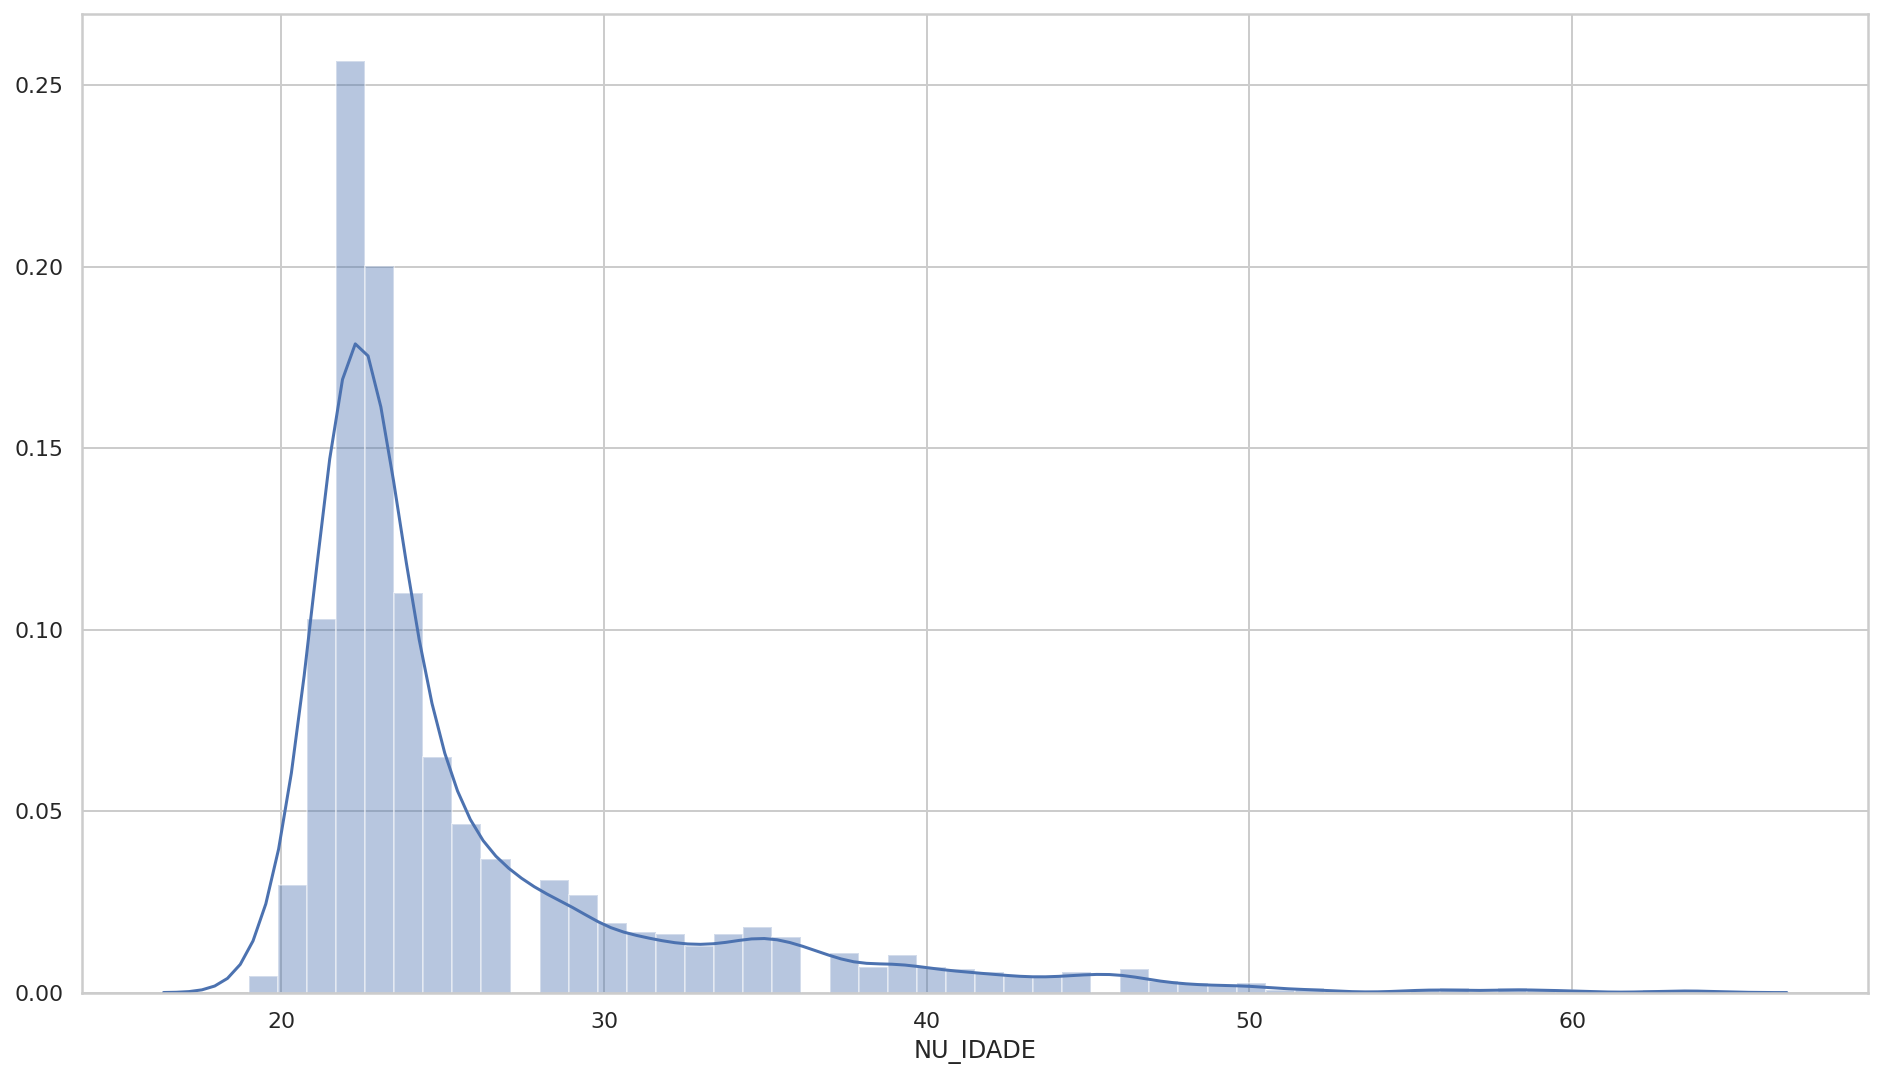

In [9]:
sns.distplot(df.NU_IDADE)

In [10]:
cols = socio_cols + ['TP_SEXO', 'NU_IDADE']

In [11]:
cols

['QE_I01',
 'QE_I02',
 'QE_I04',
 'QE_I05',
 'QE_I06',
 'QE_I07',
 'QE_I08',
 'QE_I09',
 'QE_I10',
 'QE_I11',
 'QE_I12',
 'QE_I13',
 'QE_I14',
 'QE_I15',
 'QE_I17',
 'QE_I18',
 'QE_I19',
 'QE_I20',
 'QE_I21',
 'QE_I22',
 'QE_I23',
 'QE_I24',
 'QE_I25',
 'TP_SEXO',
 'NU_IDADE']

## Transforming data

In [12]:
cats = cols
cats.remove('NU_IDADE')

In [13]:
enc = preprocessing.OneHotEncoder(sparse=False)
# fit and transform in one call and print categories
out_enc = enc.fit_transform(df[cats])
new_cols = enc.get_feature_names(cats).tolist()
print(new_cols)

['QE_I01_A', 'QE_I01_B', 'QE_I01_C', 'QE_I01_D', 'QE_I01_E', 'QE_I02_A', 'QE_I02_B', 'QE_I02_C', 'QE_I02_D', 'QE_I02_E', 'QE_I02_F', 'QE_I04_A', 'QE_I04_B', 'QE_I04_C', 'QE_I04_D', 'QE_I04_E', 'QE_I04_F', 'QE_I05_A', 'QE_I05_B', 'QE_I05_C', 'QE_I05_D', 'QE_I05_E', 'QE_I05_F', 'QE_I06_A', 'QE_I06_B', 'QE_I06_C', 'QE_I06_D', 'QE_I06_F', 'QE_I07_A', 'QE_I07_B', 'QE_I07_C', 'QE_I07_D', 'QE_I07_E', 'QE_I07_F', 'QE_I07_G', 'QE_I07_H', 'QE_I08_A', 'QE_I08_B', 'QE_I08_C', 'QE_I08_D', 'QE_I08_E', 'QE_I08_F', 'QE_I08_G', 'QE_I09_A', 'QE_I09_B', 'QE_I09_C', 'QE_I09_D', 'QE_I09_E', 'QE_I09_F', 'QE_I10_A', 'QE_I10_B', 'QE_I10_C', 'QE_I10_D', 'QE_I10_E', 'QE_I11_A', 'QE_I11_B', 'QE_I11_C', 'QE_I11_D', 'QE_I11_E', 'QE_I11_F', 'QE_I11_G', 'QE_I11_H', 'QE_I11_I', 'QE_I11_J', 'QE_I11_K', 'QE_I12_A', 'QE_I12_B', 'QE_I12_C', 'QE_I12_D', 'QE_I12_E', 'QE_I12_F', 'QE_I13_A', 'QE_I13_B', 'QE_I13_C', 'QE_I13_D', 'QE_I13_E', 'QE_I13_F', 'QE_I14_A', 'QE_I14_B', 'QE_I14_E', 'QE_I14_F', 'QE_I15_A', 'QE_I15_B', 'QE

### Crate temporary dataframe for concatenation with original data

In [14]:
df_enc = pd.DataFrame(data=out_enc, columns=new_cols)
df_enc.index = df.index

In [15]:
# drop original columns and concatenate new encoded columns
df.drop(cats, axis=1, inplace=True)
df = pd.concat([df, df_enc], axis=1)
print(df.columns)

Index(['NU_ANO', 'CO_IES', 'CO_GRUPO', 'NU_IDADE', 'ANO_FIM_EM', 'ANO_IN_GRAD',
       'QE_I01_A', 'QE_I01_B', 'QE_I01_C', 'QE_I01_D',
       ...
       'QE_I25_A', 'QE_I25_B', 'QE_I25_C', 'QE_I25_D', 'QE_I25_E', 'QE_I25_F',
       'QE_I25_G', 'QE_I25_H', 'TP_SEXO_F', 'TP_SEXO_M'],
      dtype='object', length=149)


### Feature selection

In [16]:
selector = VarianceThreshold() # instantiate with no threshold

In [17]:
# prefit object with df[cols]
selector.fit(df[new_cols])

VarianceThreshold()

In [18]:
# check feature variances before selection
np.quantile(selector.variances_, [0.25, 0.5, 0.75])

array([0.01285855, 0.05557364, 0.15295342])

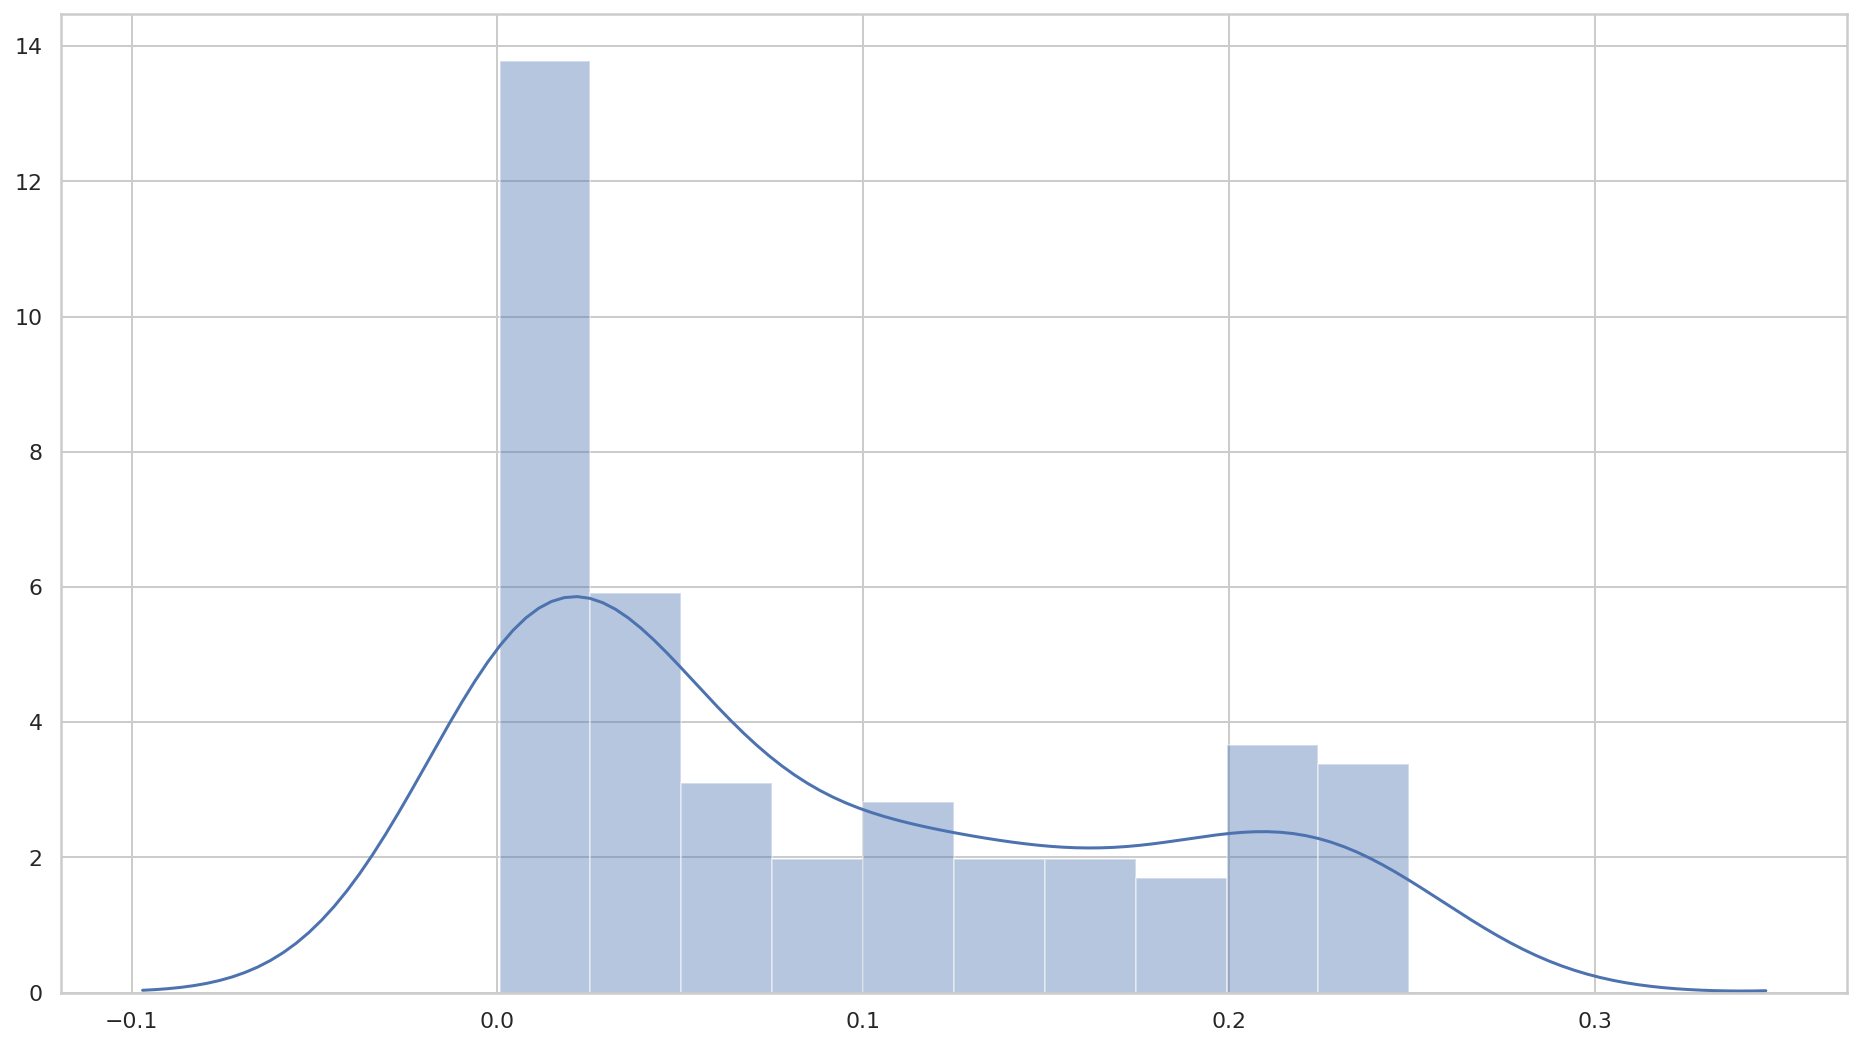

In [19]:
sns.distplot(selector.variances_, bins=10)

In [20]:
# set threshold into selector object
selector.set_params(threshold=np.quantile(selector.variances_, 0.5))

# refit and transform, store output in out_sel
out_sel = selector.fit_transform(df[new_cols])

# check which features were chosen
print(selector.get_support())

[ True  True False False False  True False False  True False False False
  True  True  True  True False False  True  True  True  True False False
  True  True False False  True  True  True  True  True False False False
  True  True  True  True  True False False  True  True  True  True  True
  True  True  True  True  True  True False  True  True False  True False
 False  True False False False False False False False False False  True
 False False False False  True False False False False  True False False
 False False False  True  True False False False False  True False False
 False False  True  True False False False False False  True False  True
 False False False  True  True False False False  True  True  True  True
  True  True  True False  True  True  True  True  True False False False
  True  True  True  True False  True False False  True  True  True]


In [21]:
# filter in the selected features
df_sel = df[new_cols].iloc[:, selector.get_support()]

In [22]:
df_sel.shape

(1727, 71)

In [23]:
df_sel

,QE_I01_A,QE_I01_B,QE_I02_A,QE_I02_D,QE_I04_B,QE_I04_C,QE_I04_D,QE_I04_E,QE_I05_B,QE_I05_C,QE_I05_D,QE_I05_E,QE_I06_B,QE_I06_C,QE_I07_A,QE_I07_B,QE_I07_C,QE_I07_D,QE_I07_E,QE_I08_A,QE_I08_B,QE_I08_C,QE_I08_D,QE_I08_E,QE_I09_A,QE_I09_B,QE_I09_C,QE_I09_D,QE_I09_E,QE_I09_F,QE_I10_A,QE_I10_B,QE_I10_C,QE_I10_D,QE_I10_E,QE_I11_B,QE_I11_C,QE_I11_E,QE_I11_H,QE_I13_A,QE_I13_F,QE_I15_A,QE_I17_A,QE_I17_B,QE_I18_A,QE_I19_A,QE_I19_B,QE_I20_A,QE_I20_C,QE_I20_G,QE_I20_H,QE_I21_A,QE_I21_B,QE_I22_A,QE_I22_B,QE_I22_C,QE_I22_D,QE_I22_E,QE_I23_B,QE_I23_C,QE_I23_D,QE_I23_E,QE_I24_A,QE_I24_E,QE_I25_A,QE_I25_B,QE_I25_C,QE_I25_E,QE_I25_H,TP_SEXO_F,TP_SEXO_M
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1722,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1723,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1724,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1725,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [24]:
df[new_cols]

,QE_I01_A,QE_I01_B,QE_I01_C,QE_I01_D,QE_I01_E,QE_I02_A,QE_I02_B,QE_I02_C,QE_I02_D,QE_I02_E,QE_I02_F,QE_I04_A,QE_I04_B,QE_I04_C,QE_I04_D,QE_I04_E,QE_I04_F,QE_I05_A,QE_I05_B,QE_I05_C,QE_I05_D,QE_I05_E,QE_I05_F,QE_I06_A,QE_I06_B,QE_I06_C,QE_I06_D,QE_I06_F,QE_I07_A,QE_I07_B,QE_I07_C,QE_I07_D,QE_I07_E,QE_I07_F,QE_I07_G,QE_I07_H,QE_I08_A,QE_I08_B,QE_I08_C,QE_I08_D,QE_I08_E,QE_I08_F,QE_I08_G,QE_I09_A,QE_I09_B,QE_I09_C,QE_I09_D,QE_I09_E,QE_I09_F,QE_I10_A,QE_I10_B,QE_I10_C,QE_I10_D,QE_I10_E,QE_I11_A,QE_I11_B,QE_I11_C,QE_I11_D,QE_I11_E,QE_I11_F,...,QE_I15_C,QE_I15_D,QE_I15_E,QE_I15_F,QE_I17_A,QE_I17_B,QE_I17_C,QE_I17_D,QE_I17_E,QE_I17_F,QE_I18_A,QE_I18_B,QE_I18_C,QE_I18_D,QE_I18_E,QE_I19_A,QE_I19_B,QE_I19_C,QE_I19_D,QE_I19_E,QE_I19_F,QE_I19_G,QE_I20_A,QE_I20_B,QE_I20_C,QE_I20_D,QE_I20_E,QE_I20_F,QE_I20_G,QE_I20_H,QE_I20_I,QE_I20_J,QE_I20_K,QE_I21_A,QE_I21_B,QE_I22_A,QE_I22_B,QE_I22_C,QE_I22_D,QE_I22_E,QE_I23_A,QE_I23_B,QE_I23_C,QE_I23_D,QE_I23_E,QE_I24_A,QE_I24_B,QE_I24_C,QE_I24_D,QE_I24_E,QE_I25_A,QE_I25_B,QE_I25_C,QE_I25_D,QE_I25_E,QE_I25_F,QE_I25_G,QE_I25_H,TP_SEXO_F,TP_SEXO_M
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [25]:
df[new_cols].to_csv('../data/preprocessed/enade_2016a2018_priv_onehot_full.csv', index=False)

In [26]:
df_sel.to_csv('../data/preprocessed/enade_2016a2018_priv_onehot_sel.csv', index=False)